# 表徵聚類(Clustering Using Representatives)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist,pdist
import time

# MNIST Dataset

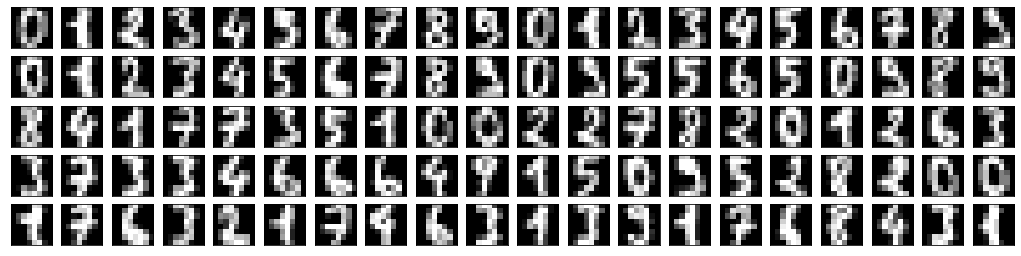

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=(digits.data/16)
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Principal Component Anlysis

In [3]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded

# CURE
the code is modified from pyclustering packages

In [4]:
from pyclustering.core.wrapper import ccore_library
import pyclustering.core.cure_wrapper as wrapper
class cure_cluster:
    def __init__(self, point, index):
        self.points = [ ] 
        self.indexes = -1 
        self.mean = None 
        self.rep = [ ] 
        if point is not None:
            self.points = [ point ]
            self.indexes = [ index ]
            self.mean = point
            self.rep = [ point ]
        self.closest = None 
        self.distance = float('inf')
    def __repr__(self):
        return "%s, %s" % (self.distance, self.points)
         
class cure:
    def __init__(self, data, number_cluster, number_represent_points = 5, compression = 0.5, ccore = True):
        self.__pointer_data = self.__prepare_data_points(data)
        self.__clusters = None
        self.__representors = None
        self.__means = None 
        self.__number_cluster = number_cluster
        self.__number_represent_points = number_represent_points
        self.__compression = compression 
        self.__ccore = ccore
        if self.__ccore:
            self.__ccore = ccore_library.workable()
        self.__validate_arguments()
        
    def process(self):
        if self.__ccore is True:
            self.__process_by_ccore() 
        else:
            self.__process_by_python()
            
    def __process_by_ccore(self):
        cure_data_pointer = wrapper.cure_algorithm(self.__pointer_data, self.__number_cluster,
                                                    self.__number_represent_points, self.__compression)
        self.__clusters = wrapper.cure_get_clusters(cure_data_pointer)
        self.__representors = wrapper.cure_get_representors(cure_data_pointer)
        self.__means = wrapper.cure_get_means(cure_data_pointer)
        wrapper.cure_data_destroy(cure_data_pointer)
    
    def __process_by_python(self):
        self.__create_queue()
        self.__create_kdtree() 
        while len(self.__queue) > self.__number_cluster:
            cluster1 = self.__queue[0]  
            cluster2 = cluster1.closest 
            self.__queue.remove(cluster1)
            self.__queue.remove(cluster2)
            self.__delete_represented_points(cluster1)
            self.__delete_represented_points(cluster2)
            merged_cluster = self.__merge_clusters(cluster1, cluster2)
            self.__insert_represented_points(merged_cluster)
            cluster_relocation_requests = []
            if len(self.__queue) > 0:
                merged_cluster.closest = self.__queue[0]
                merged_cluster.distance = self.__cluster_distance(merged_cluster, merged_cluster.closest)
                for item in self.__queue:
                    distance = self.__cluster_distance(merged_cluster, item)
                    if distance < merged_cluster.distance:
                        merged_cluster.closest = item
                        merged_cluster.distance = distance
                    if (item.closest is cluster1) or (item.closest is cluster2):
                        if item.distance < distance:
                            (item.closest, item.distance) = self.__closest_cluster(item, distance)
                            if item.closest is None:
                                item.closest = merged_cluster
                                item.distance = distance
                        else:
                            item.closest = merged_cluster
                            item.distance = distance
                        cluster_relocation_requests.append(item)
            self.__insert_cluster(merged_cluster)
            for item in cluster_relocation_requests:
                self.__relocate_cluster(item)
        self.__clusters = [cure_cluster_unit.indexes for cure_cluster_unit in self.__queue]
        self.__representors = [cure_cluster_unit.rep for cure_cluster_unit in self.__queue]
        self.__means = [cure_cluster_unit.mean for cure_cluster_unit in self.__queue]

    def get_clusters(self):
        return self.__clusters
    
    def get_representors(self):
        return self.__representors
    
    def get_means(self):
        return self.__means
    
    def get_cluster_encoding(self):
        return type_encoding.CLUSTER_INDEX_LIST_SEPARATION


    def __prepare_data_points(self, sample):
        if isinstance(sample, np.ndarray):
            return sample.tolist()
        return sample

    def __validate_arguments(self):
        if len(self.__pointer_data) == 0:
            raise ValueError("Empty input data. Data should contain at least one point.")
        if self.__number_cluster <= 0:
            raise ValueError("Incorrect amount of clusters '%d'. Amount of cluster should be greater than 0." % self.__number_cluster)
        if self.__compression < 0:
            raise ValueError("Incorrect compression level '%f'. Compression should not be negative." % self.__compression)
        if self.__number_represent_points <= 0:
            raise ValueError("Incorrect amount of representatives '%d'. Amount of representatives should be greater than 0." % self.__number_cluster)

    def __insert_cluster(self, cluster):
        for index in range(len(self.__queue)):
            if cluster.distance < self.__queue[index].distance:
                self.__queue.insert(index, cluster)
                return
        self.__queue.append(cluster)

    def __relocate_cluster(self, cluster):
        self.__queue.remove(cluster)
        self.__insert_cluster(cluster)

    def __closest_cluster(self, cluster, distance):
        nearest_cluster = None
        nearest_distance = float('inf')
        real_euclidean_distance = distance ** 0.5
        for point in cluster.rep:
            nearest_nodes = self.__tree.find_nearest_dist_nodes(point, real_euclidean_distance)
            for (candidate_distance, kdtree_node) in nearest_nodes:
                if (candidate_distance < nearest_distance) and (kdtree_node is not None) and (kdtree_node.payload is not cluster):
                    nearest_distance = candidate_distance
                    nearest_cluster = kdtree_node.payload 
        return (nearest_cluster, nearest_distance)

    def __insert_represented_points(self, cluster):
        for point in cluster.rep:
            self.__tree.insert(point, cluster)

    def __delete_represented_points(self, cluster): 
        for point in cluster.rep:
            self.__tree.remove(point, payload=cluster)
    
    def __merge_clusters(self, cluster1, cluster2):
        merged_cluster = cure_cluster(None, None) 
        merged_cluster.points = cluster1.points + cluster2.points
        merged_cluster.indexes = cluster1.indexes + cluster2.indexes 
        dimension = len(cluster1.mean)
        merged_cluster.mean = [0] * dimension
        if merged_cluster.points[1:] == merged_cluster.points[:-1]:
            merged_cluster.mean = merged_cluster.points[0]
        else:
            for index in range(dimension):
                merged_cluster.mean[index] = ( len(cluster1.points) * cluster1.mean[index] + len(cluster2.points) * cluster2.mean[index] ) / ( len(cluster1.points) + len(cluster2.points) );
        temporary = list() 
        for index in range(self.__number_represent_points):
            maximal_distance = 0
            maximal_point = None 
            for point in merged_cluster.points:
                minimal_distance = 0
                if index == 0:
                    minimal_distance = euclidean_distance_square(point, merged_cluster.mean)
                else:
                    minimal_distance = min([euclidean_distance_square(point, p) for p in temporary])                     
                if minimal_distance >= maximal_distance:
                    maximal_distance = minimal_distance
                    maximal_point = point
            if maximal_point not in temporary:
                temporary.append(maximal_point)
        for point in temporary:
            representative_point = [0] * dimension
            for index in range(dimension):
                representative_point[index] = point[index] + self.__compression * (merged_cluster.mean[index] - point[index]) 
            merged_cluster.rep.append(representative_point)
        return merged_cluster
    
    def __create_queue(self):
        self.__queue = [cure_cluster(self.__pointer_data[index_point], index_point) for index_point in range(len(self.__pointer_data))] 
        for i in range(0, len(self.__queue)):
            minimal_distance = float('inf')
            closest_index_cluster = -1 
            for k in range(0, len(self.__queue)):
                if i != k:
                    dist = self.__cluster_distance(self.__queue[i], self.__queue[k])
                    if dist < minimal_distance:
                        minimal_distance = dist
                        closest_index_cluster = k
            self.__queue[i].closest = self.__queue[closest_index_cluster]
            self.__queue[i].distance = minimal_distance
        self.__queue.sort(key = lambda x: x.distance, reverse = False)
        
    def __create_kdtree(self):
        self.__tree = kdtree()
        for current_cluster in self.__queue:
            for representative_point in current_cluster.rep:
                self.__tree.insert(representative_point, current_cluster)

    def __cluster_distance(self, cluster1, cluster2):
        distance = float('inf')
        for i in range(0, len(cluster1.rep)):
            for k in range(0, len(cluster2.rep)):
                dist = euclidean_distance_square(cluster1.rep[i], cluster2.rep[k])
                if dist < distance:
                    distance = dist 
        return distance

In [5]:
number=48
cure_instance = cure(X, number, 5, 0, True)
cure_instance.process()
clusters = cure_instance.get_clusters()

# Plot

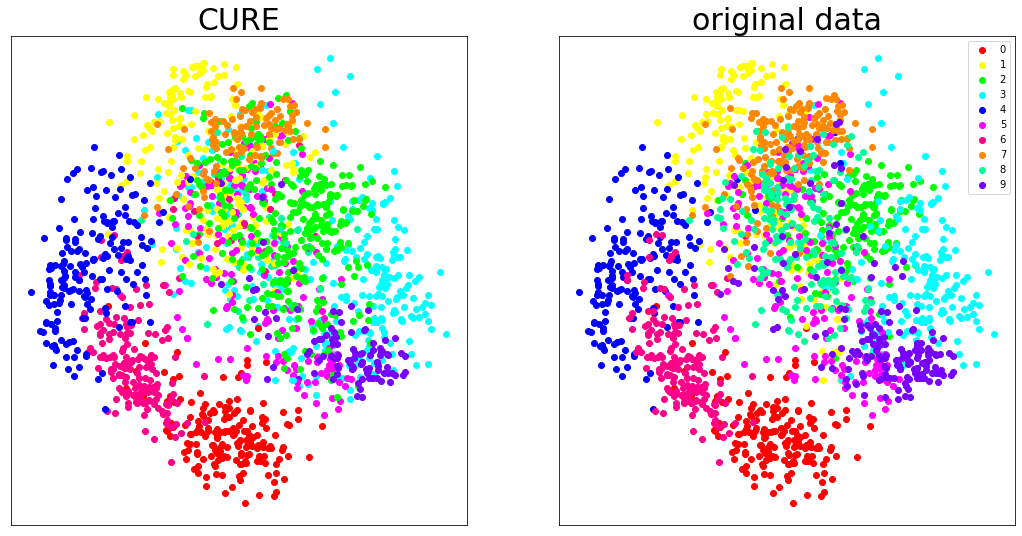

In [8]:
N=X.shape[0]
X_embedded=PCA(X,2,N)
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,9)
fig , ax = plt.subplots()
plt.subplot(1, 2, 1)
for i in range(0,number):
    index = np.argmax(np.bincount(y[clusters[i]]))
    plt.scatter(X_embedded[clusters[i],0],X_embedded[clusters[i],1],c=color[index])
plt.title("CURE",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
for i in range(0,10):
    plt.scatter(X_embedded[(y==i),0],X_embedded[(y==i),1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()